In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
import pickle
import pdfplumber
import os
import re
import numpy as np

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

#from P4utilities import get_top_n_words
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import pyLDAvis.gensim

from sklearn.feature_extraction import text
import heapq

/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



**Load CEJA**

In [6]:
ceja = pickle.load( open( "ceja_bypage.pkl", "rb" ) )

In [7]:
ceja

text
0                 AL ASSEMBLY State of Illinois  and  
1    M. Williams SYNOPSIS AS INTRODUCED: See Index ...
2    T concerning regulation.  Be it enacted by the...
3    the State of Illinois should pursue immediate ...
4    off-peak hours.  (g) The State of Illinois sho...
..                                                 ...
902  this Section shall submit to the Department of...
903  effective date of this amendatory Act of the n...
904  INDEX  Statutes amended in order of appearance...
905   ILCS /-. new   ILCS /- from Ch.  /, par. -   ...
906   ILCS /. new   ILCS /. rep.   ILCS / new   ILC...

[907 rows x 1 columns]

# EDA

**Length of pages: maybe more relevant to show Section length?**

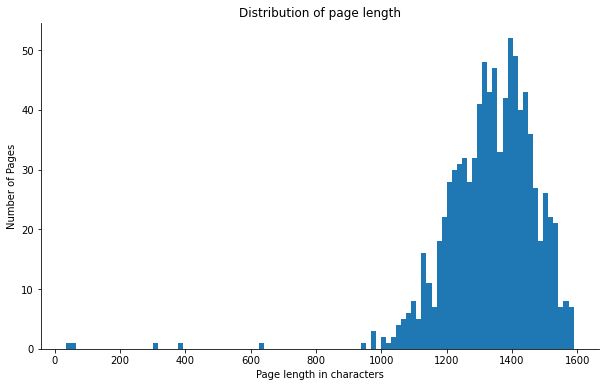

In [8]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in ceja.text]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of page length')
plt.ylabel('Number of Pages')
plt.xlabel('Page length in characters')
sns.despine();

In [9]:
len(ceja.text.loc[10].split())

197

**Word cloud for CEJA**

In [10]:
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 


my_additional_stop_words = ['subsection','cumulative', 'persisting', 'section','ILC','ILCS', 'Index', 'SYNOPSIS', 'n', 'M', 'dtype', 'See', 'Section', 'AL', 'par', 'Ch', 'sho', 'T', 'g', 'ILC']

stopwords = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)


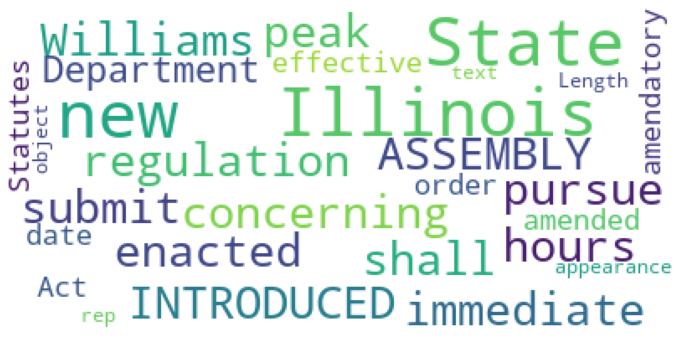

In [11]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(ceja.text))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();



**Explore Unigrams**

In [12]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [13]:
common_words = get_top_n_words(ceja.text, 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 unigrams in CEJA"), xaxis = dict(tickangle=45))
fig.show()

/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'ch', 'ilc', 'ilcs', 'index', 'synopsis'] not in stop_words.



**Explore bigrams**

In [14]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [15]:
common_words = get_top_n_bigram(ceja.text, 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in CEJA"))
fig.show()

/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'ch', 'ilc', 'ilcs', 'index', 'synopsis'] not in stop_words.



*Use same image above on next page of presentation, but with highlight on "shall", to lead into discussion of burden identification and subjects clustering*

In [16]:
common_words[0][0]

'renewable energy'

**Identify pages with most burdens**

In [17]:
type(ceja.text)

pandas.core.series.Series

Tweak bigram function to return bigrams with "shall" and extract subject before "shall" from bigram



In [18]:
def entities(corpus):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

Tweak unigram function to return unigrams with "shall" and number of times unigram containing "shall" appears on page



In [19]:
def burdens(corpus):
    vec = CountVectorizer(stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [20]:
entities(pd.Series(ceja.text.loc[88]))[0][0]

'clean energy'

In [21]:
# solution to extract subjects

#[item[0].split()[0] for item in a if 'shall' == item[0].split()[1]]

In [22]:
entities(pd.Series(ceja.text))

[('renewable energy', 416),
 ('clean energy', 316),
 ('electric utility', 288),
 ('energy efficiency', 262),
 ('commission shall', 250),
 ('utility shall', 216),
 ('low income', 186),
 ('annual savings', 185),
 ('retail customers', 176),
 ('procurement plan', 172),
 ('general assembly', 162),
 ('delivery year', 159),
 ('shall include', 157),
 ('energy credits', 153),
 ('ending december', 153),
 ('electric vehicle', 150),
 ('set forth', 150),
 ('effective date', 147),
 ('agency shall', 142),
 ('energy resources', 136),
 ('year ending', 136),
 ('illinois power', 132),
 ('power agency', 128),
 ('participating utility', 124),
 ('department shall', 118),
 ('energy empowerment', 113),
 ('environmental justice', 112),
 ('public utilities', 111),
 ('public utility', 108),
 ('including limited', 106),
 ('taxable year', 104),
 ('long term', 102),
 ('savings year', 93),
 ('zero emission', 92),
 ('shall provide', 91),
 ('community based', 90),
 ('multi year', 90),
 ('utilities act', 88),
 ('taxabl

In [23]:
# solution to extract number of burdens, as defined by the word 'shall'

#[item[1] for item in b if item[0] == 'shall'][0]

In [24]:
def b(x):
    if len([item[1] for item in burdens(pd.Series(x)) if item[0] == 'shall']):
        return [item[1] for item in burdens(pd.Series(x)) if item[0] == 'shall'][0]
    else:
        return 0

In [25]:
def e(x):

    if len([item[0].split()[0] for item in entities(pd.Series(x)) if 'shall' == item[0].split()[1]]):
        return [item[0].split()[0] for item in entities(pd.Series(x)) if 'shall' == item[0].split()[1]]
    else:
        return None

Now that we have the functions tested out and working, appy to CEJA to create new columns for number of burdens on page and which subjects are responsible

In [26]:
ceja['burdens'] = ceja.text.apply(lambda x: b(x))

In [27]:
ceja['subjects'] = ceja.text.apply(lambda x: e(x))

Why does one page have a "shall" without a preceding subject?...

In [28]:
ceja.loc[(ceja.burdens!=0) & (ceja.subjects.isna())]

text  burdens subjects
902  this Section shall submit to the Department of...        1     None

In [29]:
print(ceja.text.loc[902])

this Section shall submit to the Department of Commerce and  Economic Opportunity and the Agency a report detailing the  total amount of funds collected from any Nuclear Impact Fees,  the planned expenditure of the funds, the coordination of  expenditure with any Department economic transition activities  and investments, copies of any adoption of or amendments to  resolutions or ordinances impacting the assessment of Nuclear  Impact Fees, and a certification of the remittance of the  State portion of the funds collected to the Department of  Revenue.  (n) The Department of Commerce and Economic Opportunity  may establish such rules as it deems necessary to implement  this Section.  Section -. The Prevailing Wage Act is amended by  adding Section . as follows:  ( ILCS /. new)  Sec. .. Job classifications. The Department of Labor  must, within  days after the effective date of this  amendatory Act of the nd General Assembly, identify job  categories for laborers, mechanics, and other wo

...Because "Section" was added to stopwords

In [30]:
ceja.subjects.loc[902] = 'section'

/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
ceja.subjects.loc[902]

'section'

In [32]:
ceja.loc[(ceja.burdens!=0) & (ceja.subjects.isna())]

Empty DataFrame
Columns: [text, burdens, subjects]
Index: []

Confirmed replacing the None value with "Section" worked

**Do the subjects make sense? Does the number of burdens add up to the total?**

In [33]:
# YES. Total accounted for
ceja.burdens.sum()

2959

In [34]:
ceja.subjects[~ceja.subjects.isna()].tolist()

[['agencies'],
 ['board', 'opportunity', 'programs'],
 ['department', 'meetings', 'advance'],
 ['board', 'area', 'department', 'approval', 'programs', 'program'],
 ['department', 'implementation', 'activities', 'processes', 'act', 'board'],
 ['board'],
 ['board', 'members', 'department'],
 ['board', 'department'],
 ['administrators'],
 ['administrators', 'department', 'programs'],
 ['department', 'administrators'],
 ['department', 'administrators', 'board'],
 ['listed', 'department', 'act'],
 ['department', 'program'],
 ['network', 'sites'],
 ['sites', 'site', 'organization', 'act', 'board'],
 ['network'],
 ['strategies', 'stipend'],
 ['activities', 'department'],
 ['updates', 'tracking', 'act', 'functions'],
 ['department', 'board', 'program'],
 ['administrator', 'department'],
 ['department'],
 ['department', 'report', 'evaluation', 'evaluator', 'website'],
 ['department', 'curriculum'],
 ['department', 'group'],
 ['year', 'program'],
 ['program', 'department'],
 ['sites', 'site', 'o

In [35]:
flat_list = [item for sublist in ceja.subjects[~ceja.subjects.isna()].tolist() for item in sublist]

In [36]:
flat_list

['agencies',
 'board',
 'opportunity',
 'programs',
 'department',
 'meetings',
 'advance',
 'board',
 'area',
 'department',
 'approval',
 'programs',
 'program',
 'department',
 'implementation',
 'activities',
 'processes',
 'act',
 'board',
 'board',
 'board',
 'members',
 'department',
 'board',
 'department',
 'administrators',
 'administrators',
 'department',
 'programs',
 'department',
 'administrators',
 'department',
 'administrators',
 'board',
 'listed',
 'department',
 'act',
 'department',
 'program',
 'network',
 'sites',
 'sites',
 'site',
 'organization',
 'act',
 'board',
 'network',
 'strategies',
 'stipend',
 'activities',
 'department',
 'updates',
 'tracking',
 'act',
 'functions',
 'department',
 'board',
 'program',
 'administrator',
 'department',
 'department',
 'department',
 'report',
 'evaluation',
 'evaluator',
 'website',
 'department',
 'curriculum',
 'department',
 'group',
 'year',
 'program',
 'program',
 'department',
 'sites',
 'site',
 'organizati

In [37]:
from collections import Counter

counts = Counter(flat_list)
print(counts.most_common(4))

[('commission', 165), ('utility', 146), ('agency', 82), ('department', 68)]


commission = Energy Transition Workforce Commission
utility = public utility
agency =  (or public agency) theStateof Illinoisor anyof itsgovernmentbodiesandsubdivisions,includingthevariouscounties,townships,municipalities,schooldistricts,educationalserviceregions,specialroaddistricts,publicwatersupplydistricts,drainagedistricts,leveedistricts,sewerdistricts,housingauthorities,and transitagencies.
department = the Departmentof Commerceand EconomicOpportunity

**YES, total number of burdens accounted for AND the subjects make sense.**

In [38]:
ceja.loc[ceja.subjects.str.contains('commission', na=True)]

text  burdens  \
0                 AL ASSEMBLY State of Illinois  and          0   
1    M. Williams SYNOPSIS AS INTRODUCED: See Index ...        0   
2    T concerning regulation.  Be it enacted by the...        0   
3    the State of Illinois should pursue immediate ...        0   
4    off-peak hours.  (g) The State of Illinois sho...        1   
..                                                 ...      ...   
901  tax bills of the county if requested by a loca...        3   
903  effective date of this amendatory Act of the n...        0   
904  INDEX  Statutes amended in order of appearance...        0   
905   ILCS /-. new   ILCS /- from Ch.  /, par. -   ...        0   
906   ILCS /. new   ILCS /. rep.   ILCS / new   ILC...        0   

                        subjects  
0                           None  
1                           None  
2                           None  
3                           None  
4                     [agencies]  
..                           ...  
901  [body, collected, pursuant]  
903                         None  
904                         None  
905                         None  
906                         None  

[906 rows x 3 columns]

In [39]:
ceja.sample()

text  burdens subjects
103  interest therein;  () borrow money or guarante...        0     None

Save dataframe with burdens and subjects

In [41]:
pickle.dump( ceja, open( "ceja_withburdens.pkl", "wb" ) )

In [42]:
ceja

text  burdens    subjects
0                 AL ASSEMBLY State of Illinois  and          0        None
1    M. Williams SYNOPSIS AS INTRODUCED: See Index ...        0        None
2    T concerning regulation.  Be it enacted by the...        0        None
3    the State of Illinois should pursue immediate ...        0        None
4    off-peak hours.  (g) The State of Illinois sho...        1  [agencies]
..                                                 ...      ...         ...
902  this Section shall submit to the Department of...        1     section
903  effective date of this amendatory Act of the n...        0        None
904  INDEX  Statutes amended in order of appearance...        0        None
905   ILCS /-. new   ILCS /- from Ch.  /, par. -   ...        0        None
906   ILCS /. new   ILCS /. rep.   ILCS / new   ILC...        0        None

[907 rows x 3 columns]

**Explore trigrams**

In [43]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [44]:
common_words = get_top_n_trigram(ceja.text, 20)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 trigrams in CEJA"))
fig.show()

/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'ch', 'ilc', 'ilcs', 'index', 'synopsis'] not in stop_words.



In [45]:
common_words

[('renewable energy credits', 152),
 ('illinois power agency', 128),
 ('clean energy empowerment', 112),
 ('year ending december', 109),
 ('renewable energy resources', 95),
 ('annual savings year', 91),
 ('savings year ending', 89),
 ('public utilities act', 88),
 ('illinois commerce commission', 76),
 ('energy empowerment zone', 75),
 ('electric vehicle charging', 73),
 ('electric utility shall', 71),
 ('environmental justice communities', 69),
 ('commerce economic opportunity', 69),
 ('power agency act', 65),
 ('long term renewable', 65),
 ('term renewable resources', 63),
 ('renewable resources procurement', 63),
 ('clean energy jobs', 62),
 ('days effective date', 62)]

## Summarizing each Section

Split CEJA bill into Sections for summarization and to later apply topics derived from Pages split

In [46]:
ceja_bysection = pickle.load( open( "test_bill.pkl", "rb" ) )

In [47]:
ceja_bysection

'HB0804\n*LRB10210881SPS16211b*\n102ND GENERAL ASSEMBLY\nState of Illinois\n2021 and 2022\nHB0804\nby Rep. Ann M. Williams\nSYNOPSIS AS INTRODUCED:\nSee Index\nCreates the Clean Jobs, Workforce and Contractor Equity Act. Creates\nthe Equity and Empowerment in Clean Energy Advisory Board to administer\nthe Clean Jobs Workforce Hubs Program, the Expanding Clean Energy\nEntrepreneurship and Contractor Incubator Network Program, the Returning\nResidents Clean Jobs Training Program, and the Illinois Clean Energy\nBlack, Indigenous, and People of Color Primes Contractor Accelerator.\nCreates the Illinois Clean Energy Jobs and Justice Fund Act, the Community\nEnergy, Climate, and Jobs Planning Act, the Energy Community Reinvestment\nAct, the Clean Energy Empowerment Zone Tax Credit Act, the Coal Severance\nFee Act, the Building Energy Performance Standard Act, and the Public\nUtilities Intervenor Compensation Act. Amends the Illinois Administrative\nProcedure Act to allow for emergency rulema

In [48]:
ceja_bysection = ceja_bysection.replace("SPS", "").replace("LRB", "").replace("\n", " ").replace("\\", "").replace("%", "")

In [49]:
len(ceja_bysection)

1299631

In [50]:
len(re.split('Section [0-9]+-[0-9]+\.', ceja_bysection))

249

In [51]:
bysection = pd.DataFrame()
bysection['text'] = re.split('Section [0-9]+-[0-9]+\.', ceja_bysection)

In [52]:
bysection

text
0    HB0804 *1021088116211b* 102ND GENERAL ASSEMBLY...
1     Findings. The General Assembly finds that: 6 ...
2     Short title. This Article may be cited as 4 t...
3     Findings. 6 (a) The General Assembly finds th...
4     Power of the Department. The Department may 6...
..                                                 ...
244   The Environmental Protection Act is amended 4...
245   The Illinois Nuclear Facility Safety Act is 6...
246   The Prevailing Wage Act is amended by 15 addi...
247   No acceleration or delay. Where this Act 6 ma...
248   Effective date. This Act takes effect upon 13...

[249 rows x 1 columns]

In [53]:
bysection.text.replace('HB0804 - 181 - 102 10881  16211 b', '', inplace=True)

In [54]:
# to replace all digits, if necessary

bysection.text.replace('\d+', '', regex=True, inplace=True)

In [55]:
bysection.text.replace('HB -  -     b ', '', regex=True, inplace=True)

**Use one section to test summarization**

In [56]:
section = bysection.text.loc[100]

In [57]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaeljehl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [58]:
def summarize(section):
    sentence_list = nltk.sent_tokenize(section)
    
    formatted_section = re.sub('[^a-zA-Z]', ' ', section)
    formatted_section = re.sub(r'\s+', ' ', formatted_section)

    word_frequencies = {}
    for word in nltk.word_tokenize(formatted_section):
        if word not in stopwords:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1
                
    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)
        
    sentence_scores = {}
    for sent in sentence_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]
                        
    summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get)

    summary = ' '.join(summary_sentences)
    return summary

In [59]:
bysection['summary'] = bysection.text.apply(lambda x: summarize(x))

How much did it summarize? Original length -> summarized length

In [60]:
len(bysection.summary.loc[244])

69

In [61]:
bysection.summary.apply(lambda x: len(x)), bysection.text.apply(lambda x:len(x))

(0       503
 1      1009
 2        96
 3       757
 4       108
        ... 
 244      69
 245     930
 246     146
 247      26
 248     211
 Name: summary, Length: 249, dtype: int64,
 0      1740
 1      5473
 2        98
 3      5461
 4       136
        ... 
 244      71
 245    5972
 246     681
 247     372
 248     815
 Name: text, Length: 249, dtype: int64)

In [62]:
bysection.summary.apply(lambda x: len(x))

0       503
1      1009
2        96
3       757
4       108
       ... 
244      69
245     930
246     146
247      26
248     211
Name: summary, Length: 249, dtype: int64

In [63]:
bysection.text.apply(lambda x:len(x))[200]

838

In [64]:
len('For eligible customers whose electric service has  not been declared competitive pursuant to Section -  of this Act as of July ,  and whose electric delivery  service is provided and measured on a kilowatt demand  basis and electric supply service is not provided based on  hourly pricing, this shall typically be accomplished  through use of a dual channel meter capable of measuring  the flow of electricity both into and out of the  customers facility at the same rate and ratio.'.split())

80

In [65]:
bysection

text  \
0    HB *b* ND GENERAL ASSEMBLY State of Illinois  ...   
1     Findings. The General Assembly finds that:  (...   
2     Short title. This Article may be cited as  th...   
3     Findings.  (a) The General Assembly finds tha...   
4     Power of the Department. The Department may  ...   
..                                                 ...   
244   The Environmental Protection Act is amended  ...   
245   The Illinois Nuclear Facility Safety Act is  ...   
246   The Prevailing Wage Act is amended by  adding...   
247   No acceleration or delay. Where this Act  mak...   
248   Effective date. This Act takes effect upon  b...   

                                               summary  
0    b FISCAL NOTE ACT MAY APPLY A BILL FORHB     b...  
1    (j) Illinois' policy approach must ensure the ...  
2     Short title. This Article may be cited as  th...  
3    By contrast, white Americans make up  percent ...  
4    The Department may  adopt such rules as the Di...  
..                                                 ...  
244   The Environmental Protection Act is amended  ...  
245  (e) The Nuclear Impact Fee permission granted ...  
246   The Prevailing Wage Act is amended by  adding...  
247                          No acceleration or delay.  
248  new   ILCS /-. new   ILCS /. new   ILCS /   IL...  

[249 rows x 2 columns]

To look at more text in dataframes to see impact of functions

In [66]:
pd.options.display.max_colwidth = 1000

In [67]:
bysection.loc[200]

text        of  this Act.  () For eligible customers whose electric service has  not been declared competitive pursuant to Section -  of this Act as of July ,  and whose electric delivery  service is provided and measured on a kilowatt demand  basis and electric supply service is not provided based on  hourly pricing, this shall typically be accomplished  through use of a dual channel meter capable of measuring  the flow of electricity both into and out of the  customer's facility at the same rate and ratio. If such  customer's existing electric revenue meter does not meet  this requirement, then the electricity provider shall  arrange for the local electric utility or a meter service  provider to install and maintain a new revenue meter at  the electricity provider's expense, which may be the smart  meter described by subsection (b) of 
summary                                                                                                                                               

# Topic Modeling

**Extract topics from CEJA broken by Page before investigating Sections**

In [69]:
# first vectorize data
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words=stopwords,             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

data_vectorized = vectorizer.fit_transform(ceja.text)

# then feed into lda model
lda_model = LatentDirichletAllocation(n_components=5, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ilc', 'ilcs', 'index', 'synopsis'] not in stop_words.



In [70]:
words = vectorizer.get_feature_names()
t = lda_model.components_.argsort(axis=1)[:,-1:-17:-1]
topic_words = [[words[e] for e in l] for l in t]
topic_words


"""
Manually named Topics

1- community building and workforce training
2- taxpayer-funded programs
3- nuclear energy in illinois
4- utilities and renewable energy procurement
5- environmental justice
"""

'\n1- community building and workforce training\n2- taxpayer-funded programs\n3- nuclear energy in illinois\n4- utilities and renewable energy procurement\n5- environmental justice\n'

In [71]:
ceja['topic'] = lda_output.argmax(axis=1)

In [72]:
ceja

text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       AL ASSEMBLY State of Illinois  and     
1    M. Williams SYNOPSIS AS INTRODUCED: See Index Creates the Clean Jobs, Workforce and Contractor Equity Act. Creates the Equity and Empowerment in Clean Energy Advisory Board to administer the Clean Jobs Workforce Hubs Program, the Expanding Clean Energy Entrepreneurship and Contractor Incubator Network Program, the Returning Residents Clean Jobs Training Program, and the Illinois Clean Energy Black, Indigenous, and People of Color Primes Contractor Accelerator. Creates the Illinois Clean Energy Jobs and Justice Fund Act, the Community Energy, Climate, and Jobs Planning Act, the Energy Community Reinvestment Act, the Clean Energy Empowerment Zone Tax Credit Act, the Coal Severance Fee Act, the Building Energy Performance Standard Act, and the Public Utilities Intervenor Compensation Act. Amends the Illinois Administrative Procedure Act to allow for emergency rulemaking. Amends the State Finance Act to create The Energy Community Reinvestment Fund, the Illinois Commerce Commission Int...   
2    T concerning regulation.  Be it enacted by the People of the State of Illinois,  represented in the General Assembly:  Article . Findings  Section -. Findings. The General Assembly finds that:  (a) The growing clean energy economy in Illinois can be a  vehicle for expanding equitable access to public health,  safety, a cleaner environment, quality jobs, economic  opportunity, and wealth-building, particularly in economically  disadvantaged communities and communities of black,  indigenous, and people of color that have had to bear the  disproportionate burden of dirty fossil fuel pollution.  (b) Placing Illinois on a path to  renewable energy is  vital to a clean energy future. To bring this vision to  fruition, our energy policy must prioritize a just transition  that incentivizes renewable development and other  carbon-reducing policies, such as energy efficiency,  beneficial electrification, and peak demand reduction, while  ensuring that the benefits and opportunities of a carb...   
3    the State of Illinois should pursue immediate action on  policies that will ensure a just and responsible phase out of  fossil fuels from the power sector to reduce harmful emissions  from Illinois power plants, support power plant communities  and workers, and allow the clean energy economy to continue  growing in every corner of Illinois.  (d) Energy efficiency should form the basis of any robust  clean energy policy. It is the cheapest clean energy resource,  and efficiency upgrades help customers manage their energy  bills directly by reducing the energy they need, and  indirectly by holding demand and prices down statewide.  (e) The transportation sector is now the leading source of  carbon pollution in Illinois, responsible for roughly  one-third of all carbon emissions. The State of Illinois  should set forth an ambitious goal to remove the equivalent of  more than ,, gasoline and diesel-powered vehicles from  our roads by quickly implementin

In [73]:
# rename topics

ceja.topic = ceja.topic.replace({0: 'Community Building & Workforce Training', 1: 'Taxpayer-funded Programs', 2: 'Status of Renewables', 3: 'Utilities & Renewable Energy Procurement', 4: 'Environmental Justice'})

In [74]:
ceja.topic

0                          Status of Renewables
1       Community Building & Workforce Training
2       Community Building & Workforce Training
3      Utilities & Renewable Energy Procurement
4      Utilities & Renewable Energy Procurement
                         ...                   
902                        Status of Renewables
903                        Status of Renewables
904                        Status of Renewables
905                        Status of Renewables
906                        Status of Renewables
Name: topic, Length: 907, dtype: object

**Make t-sne plot to see separation of topics**

In [75]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=7, metric='cosine', init='pca')
# 5-D -> 2-D
tsne_lda = tsne_model.fit_transform(lda_output)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 907 samples in 0.000s...
[t-SNE] Computed neighbors for 907 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 907 / 907
[t-SNE] Mean sigma: 0.000130
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.557915
[t-SNE] KL divergence after 1000 iterations: 0.290665


In [76]:
ceja['x_coord'] = tsne_lda[:, 0]
ceja['y_coord'] = tsne_lda[:, 1]

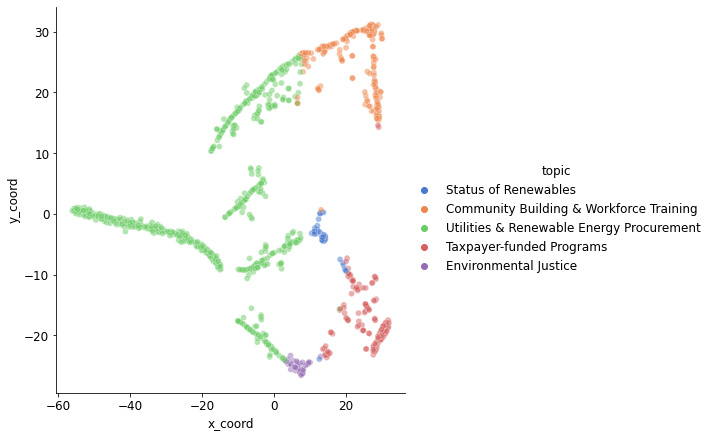

In [77]:
sns.relplot(x=ceja.x_coord, y=ceja.y_coord, hue="topic",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=ceja)

**Make wordplot for each topic**

In [78]:
type(ceja[ceja.topic=='Status of Renewables'].text)

pandas.core.series.Series

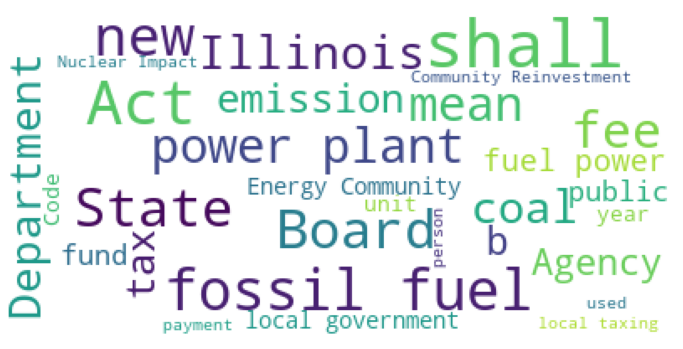

In [79]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=30,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(ceja[ceja.topic=='Status of Renewables'].text))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [80]:
ceja.topic.unique()

array(['Status of Renewables', 'Community Building & Workforce Training',
       'Utilities & Renewable Energy Procurement',
       'Taxpayer-funded Programs', 'Environmental Justice'], dtype=object)

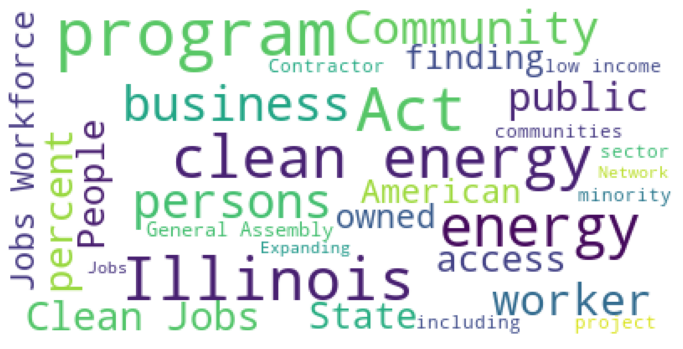

In [81]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=30,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(ceja[ceja.topic=='Community Building & Workforce Training'].text))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

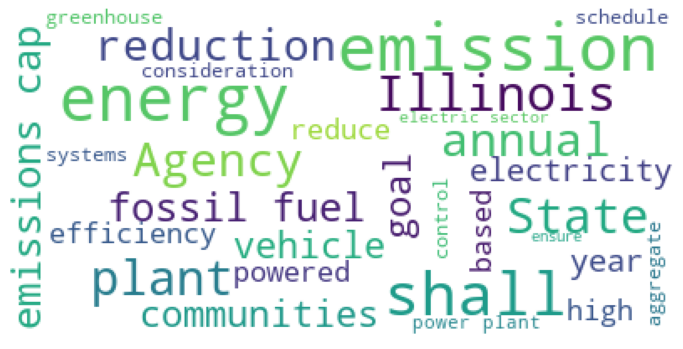

In [82]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=30,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(ceja[ceja.topic=='Utilities & Renewable Energy Procurement'].text))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

### How do burdens vary across topics?

In [83]:
burdens_by_topic = ceja.groupby('topic').sum('burdens')

In [84]:
burdens_by_topic.drop(columns=['x_coord', 'y_coord'], inplace=True)

In [85]:
burdens_by_topic.reset_index()

topic  burdens
0   Community Building & Workforce Training      526
1                     Environmental Justice      118
2                      Status of Renewables       71
3                  Taxpayer-funded Programs      409
4  Utilities & Renewable Energy Procurement     1835

In [86]:
burdens_by_topic.reset_index(inplace=True)

In [87]:
fig = go.Figure([go.Bar(x=burdens_by_topic['topic'], y=burdens_by_topic['burdens'])])
fig.update_layout(title=go.layout.Title(text="Number of Burdens per Topic"))
fig.show()

## Isolate top entities with most burdens: investigate Commission and Utilities
                               

In [88]:
t = pickle.load( open( "test_bill.pkl", "rb" ) )

In [89]:
sentence_list = nltk.sent_tokenize(t)

In [90]:
shalls = []

In [91]:
for sentence in sentence_list:
    if 'commission shall' in sentence.lower():
        shalls.append(sentence)

In [92]:
shalls

['22 (b) The Commission shall consist of the following 8\n23 members:\n24 (1) the Director of Commerce and Economic Opportunity,\n25 or his or her designee, who shall serve as chairperson;HB0804 - 139 - LRB102 10881 SPS 16211 b\n1 (2) the Director of Labor, or his or her designee;\n2 (3) the 3 program administrators of the Clean Jobs\n3 Workforce Hubs Program; and\n4 (4) 3 members appointed by the Governor, with the\n5 advice and consent of the Senate, of which at least one\n6 shall be from organized labor and at least one shall be a\n7 resident of an environmental justice community.',
 '10 (c) Members of the Commission shall serve without\n11 compensation, but may be reimbursed for necessary expenses\n12 incurred in the performance of their duties from funds\n13 appropriated for that purpose.',
 '16 (d) Within 120 days after the effective date of this Act,\n17 the Commission shall produce an Energy Transition Workforce\n18 Report regarding the anticipated impact of the energy\n19 tran

In [93]:
len(shalls)

219

In [94]:
commission = pd.DataFrame()
commission['text'] = shalls

In [95]:
commission

text
0                                                                                                                                                                                                                                                                                                                                                                                                                               22 (b) The Commission shall consist of the following 8\n23 members:\n24 (1) the Director of Commerce and Economic Opportunity,\n25 or his or her designee, who shall serve as chairperson;HB0804 - 139 - LRB102 10881 SPS 16211 b\n1 (2) the Director of Labor, or his or her designee;\n2 (3) the 3 program administrators of the Clean Jobs\n3 Workforce Hubs Program; and\n4 (4) 3 members appointed by the Governor, with the\n5 advice and consent of the Senate, of which at least one\n6 shall be from organized labor and at least one shall be a\n7 resident of an environmental justice community.
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          10 (c) Members of the Commission shall serve without\n11 compensation, but may be reimbursed for necessary expenses\n12 incurred in the performance of their duties from funds\n13 appropriated for that purpose.
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             16 (d) Within 120 days after the effective date of this Act,\n17 the Commission shall produce an Energy Transition Workforce\n18 Report regarding the anticipated impact of the energy\n19 transition and a comprehensive set of recommendations to\n20 address changes to the Illinois workforce during the period of\n21 2020 through 2050, or a later year.
3    The report shall contain\n22 the following elements, designed to be used for the programs\n23 created in this Act:\n24 (1) Information related to the impact on current\n25 workers, including:\n26 (A) a comprehensive accounting of all employeesHB0804 - 140 - LRB102 10881 SPS 16211 b\n1 who currently work in fossil fuel energy generation,\n2 nuclear energy generation, and coal mining in the\n3 State; this shall include information on their\n4 location, employer, salary ranges, full-time or\n5 part-time status, nature of their work, educational\n6 attainment, union status, and other factors the\n7 Commission finds relevant; the Commission shall keep a\n8 confidential list of these employees and the\n9 information necessary to identify them for the purpose\n10 of their eligibility to participate in programs\n11 designed for their benefit;\n12 (B) the anticipated schedule of closures of fossil\n13 fuel power plants, nuclear power plants, and coal\n14 mines across th

In [96]:
commission.text.replace('\d+', '', regex=True, inplace=True)

In [97]:
commission.text.replace("\([^()]*\)", "", regex=True, inplace=True)

In [98]:
pickle.dump( commission, open( "commissionburdens.pkl", "wb" ) )

**Now utilities burdens**

In [99]:
ut = []
for sentence in sentence_list:
    if 'utility shall' in sentence.lower():
        ut.append(sentence)

In [100]:
len(ut)

180

In [101]:
utilities = pd.DataFrame()
utilities['text'] = ut

In [102]:
utilities.text.replace('\d+', '', regex=True, inplace=True)

In [103]:
utilities.text.replace("\([^()]*\)", "", regex=True, inplace=True)

In [104]:
pd.options.display.max_colwidth = 100

In [105]:
utilities.loc[177]

text     If the facility is shown to be the least-cost option and is\n included in a procurement plan pr...
Name: 177, dtype: object

In [106]:
pickle.dump( utilities, open( "utilitiesburdens.pkl", "wb" ) )

**Transform topics from page analysis to commission and burdens dataframes**

In [107]:
def transform(text):
    vt = vectorizer.transform(pd.Series(text))
    tt = lda_model.transform(vt)
    topic = tt.argmax(axis=1)
    return topic[0]

### Using function above, transform topics onto section

In [108]:
sections = pickle.load( open( "ceja_bysection.pkl", "rb" ) )

In [109]:
ceja.topic = ceja.topic.replace({0: 'Community Building & Workforce Training', 1: 'Taxpayer-funded Programs', 2: 'Status of Renewables', 3: 'Utilities & Renewable Energy Procurement', 4: 'Environmental Justice'})

In [110]:
sections.head()

text
0  HB *b* ND GENERAL ASSEMBLY State of Illinois  and  HB by Rep. Ann M. Williams SYNOPSIS AS INTROD...
1   Findings. The General Assembly finds that:  (a) The growing clean energy economy in Illinois ca...
2    Short title. This Article may be cited as  the Clean Jobs, Workforce and Contractor Equity Act.  
3   Findings.  (a) The General Assembly finds that the clean energy jobs  sector, including renewab...
4   Power of the Department. The Department may  adopt such rules as the Director deems necessary t...

In [111]:
sections['dom_topic'] = sections.text.apply(lambda x: transform(x))

### Get topic weights for plot to show distribution of topics over the bill

In [112]:
def topic0_weights(text):
    vt = vectorizer.transform(pd.Series(text))
    tt = lda_model.transform(vt)
    #topic = tt.argmax(axis=1)
    return tt[0][0]

In [113]:
def topic1_weights(text):
    vt = vectorizer.transform(pd.Series(text))
    tt = lda_model.transform(vt)
    #topic = tt.argmax(axis=1)
    return tt[0][1]

In [114]:
def topic2_weights(text):
    vt = vectorizer.transform(pd.Series(text))
    tt = lda_model.transform(vt)
    #topic = tt.argmax(axis=1)
    return tt[0][2]

In [115]:
def topic3_weights(text):
    vt = vectorizer.transform(pd.Series(text))
    tt = lda_model.transform(vt)
    #topic = tt.argmax(axis=1)
    return tt[0][3]

In [116]:
def topic4_weights(text):
    vt = vectorizer.transform(pd.Series(text))
    tt = lda_model.transform(vt)
    #topic = tt.argmax(axis=1)
    return tt[0][4]

In [119]:
text = sections.text.loc[50]

In [120]:
vt = vectorizer.transform(pd.Series(text))
tt = lda_model.transform(vt)
print(type(tt[0][0]), tt[0][1])

<class 'numpy.float64'> 0.0014223268414568688


**Put topic weights for each section onto dataframe**

In [122]:
sections

text  \
0    HB *b* ND GENERAL ASSEMBLY State of Illinois  and  HB by Rep. Ann M. Williams SYNOPSIS AS INTROD...   
1     Findings. The General Assembly finds that:  (a) The growing clean energy economy in Illinois ca...   
2      Short title. This Article may be cited as  the Clean Jobs, Workforce and Contractor Equity Act.     
3     Findings.  (a) The General Assembly finds that the clean energy jobs  sector, including renewab...   
4     Power of the Department. The Department may  adopt such rules as the Director deems necessary t...   
..                                                                                                   ...   
244                               The Environmental Protection Act is amended  by repealing Section ..     
245   The Illinois Nuclear Facility Safety Act is  amended by adding Section  as follows:  ( ILCS / n...   
246   The Prevailing Wage Act is amended by  adding Section . as follows:  ( ILCS /. new)  Sec. .. Jo...   
247   No acceleration or delay. Where this Act  makes changes in a statute that is represented in thi...   
248   Effective date. This Act takes effect upon  becoming law.HB -  -     b  INDEX  Statutes amended...   

     dom_topic  
0            0  
1            3  
2            0  
3            0  
4            1  
..         ...  
244          2  
245          2  
246          2  
247          2  
248          2  

[249 rows x 2 columns]

In [123]:
sections['Community Building & Workforce Training'] = sections.text.apply(lambda x: topic0_weights(x))

In [124]:
sections['Taxpayer-funded programs'] = sections.text.apply(lambda x: topic1_weights(x))

In [125]:
sections['Current Status of Renewables'] = sections.text.apply(lambda x: topic2_weights(x))

In [126]:
sections['Renewable Energy Procurement'] = sections.text.apply(lambda x: topic3_weights(x))

In [127]:
sections['Environmental Justice'] = sections.text.apply(lambda x: topic4_weights(x))

In [128]:
sections

text  \
0    HB *b* ND GENERAL ASSEMBLY State of Illinois  and  HB by Rep. Ann M. Williams SYNOPSIS AS INTROD...   
1     Findings. The General Assembly finds that:  (a) The growing clean energy economy in Illinois ca...   
2      Short title. This Article may be cited as  the Clean Jobs, Workforce and Contractor Equity Act.     
3     Findings.  (a) The General Assembly finds that the clean energy jobs  sector, including renewab...   
4     Power of the Department. The Department may  adopt such rules as the Director deems necessary t...   
..                                                                                                   ...   
244                               The Environmental Protection Act is amended  by repealing Section ..     
245   The Illinois Nuclear Facility Safety Act is  amended by adding Section  as follows:  ( ILCS / n...   
246   The Prevailing Wage Act is amended by  adding Section . as follows:  ( ILCS /. new)  Sec. .. Jo...   
247   No acceleration or delay. Where this Act  makes changes in a statute that is represented in thi...   
248   Effective date. This Act takes effect upon  becoming law.HB -  -     b  INDEX  Statutes amended...   

     dom_topic  Community Building & Workforce Training  \
0            0                                 0.546123   
1            3                                 0.345538   
2            0                                 0.635927   
3            0                                 0.734105   
4            1                                 0.016943   
..         ...                                      ...   
244          2                                 0.041243   
245          2                                 0.000402   
246          2                                 0.046133   
247          2                                 0.008030   
248          2                                 0.002199   

     Taxpayer-funded programs  Current Status of Renewables  \
0                    0.201243                      0.203536   
1                    0.000446                      0.076852   
2                    0.308335                      0.018956   
3                    0.063718                      0.011852   
4                    0.931881                      0.017314   
..                        ...                           ...   
244                  0.040882                      0.837514   
245                  0.000402                      0.998402   
246                  0.003740                      0.942665   
247                  0.008059                      0.967784   
248                  0.002202                      0.991199   

     Renewable Energy Procurement  Environmental Justice  
0                        0.047929               0.001169  
1                        0.576720               0.000444  
2                        0.018538               0.018243  
3                        0.189858               0.000467  
4                        0.017083               0.016779  
..                            ...                    ...  
244                      0.040357               0.040004  
245                      0.000398               0.000396  
246                      0.003749               0.003713  
247                      0.008096               0.008031  
248                      0.002203               0.002198  

[249 rows x 7 columns]

## Sections Topic viz!

In [129]:
sections1 = sections.loc[:125]

In [130]:
sections2 = sections.loc[125:]

**Plot first half**

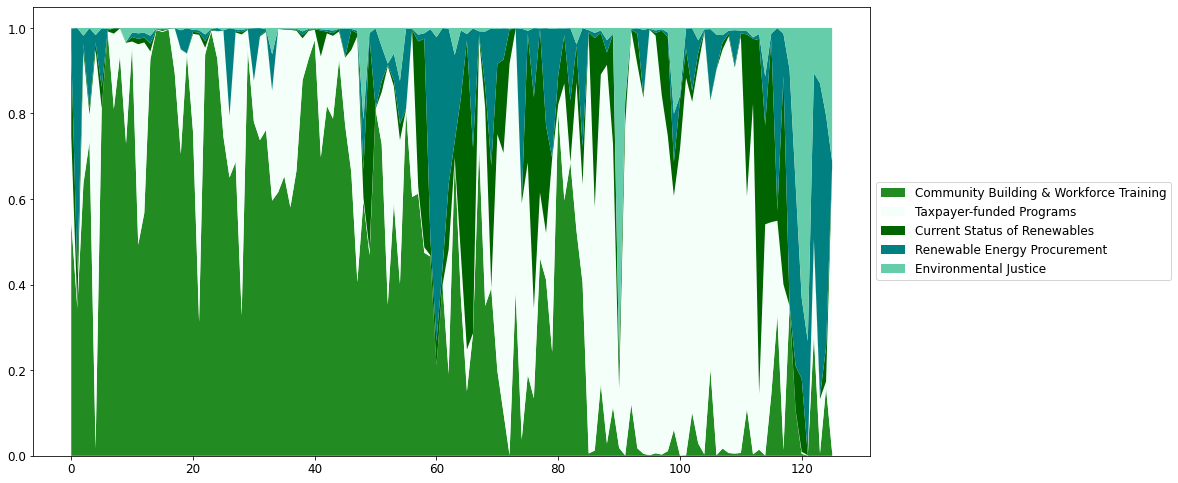

In [131]:
plt.figure(figsize=(15,8))
ax = plt.subplot(111)
plt.stackplot(sections1.index, sections1['Community Building & Workforce Training'], sections1['Taxpayer-funded programs'], sections1['Current Status of Renewables'], sections1['Renewable Energy Procurement'], sections1['Environmental Justice'], labels = ['Community Building & Workforce Training', 'Taxpayer-funded Programs', 'Current Status of Renewables', 'Renewable Energy Procurement', 'Environmental Justice'], colors=['forestgreen', 'mintcream', 'darkgreen', 'teal','mediumaquamarine']);
plt.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**Plot 2nd half**

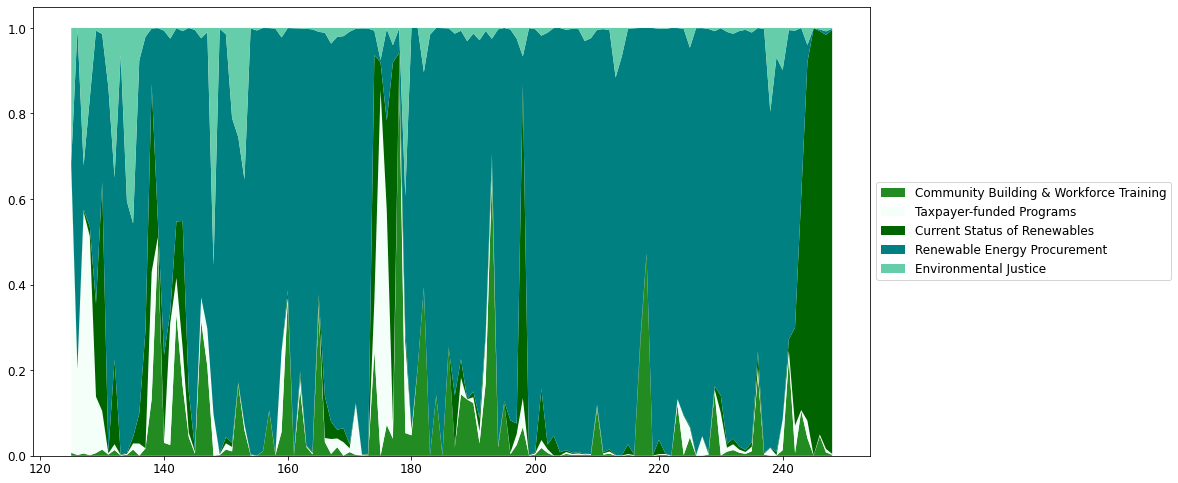

In [132]:
plt.figure(figsize=(15,8))
ax = plt.subplot(111)
plt.stackplot(sections2.index, sections2['Community Building & Workforce Training'], sections2['Taxpayer-funded programs'], sections2['Current Status of Renewables'], sections2['Renewable Energy Procurement'], sections2['Environmental Justice'], labels = ['Community Building & Workforce Training', 'Taxpayer-funded Programs', 'Current Status of Renewables', 'Renewable Energy Procurement', 'Environmental Justice'], colors=['forestgreen', 'mintcream', 'darkgreen', 'teal','mediumaquamarine']);
plt.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**Plot whole**

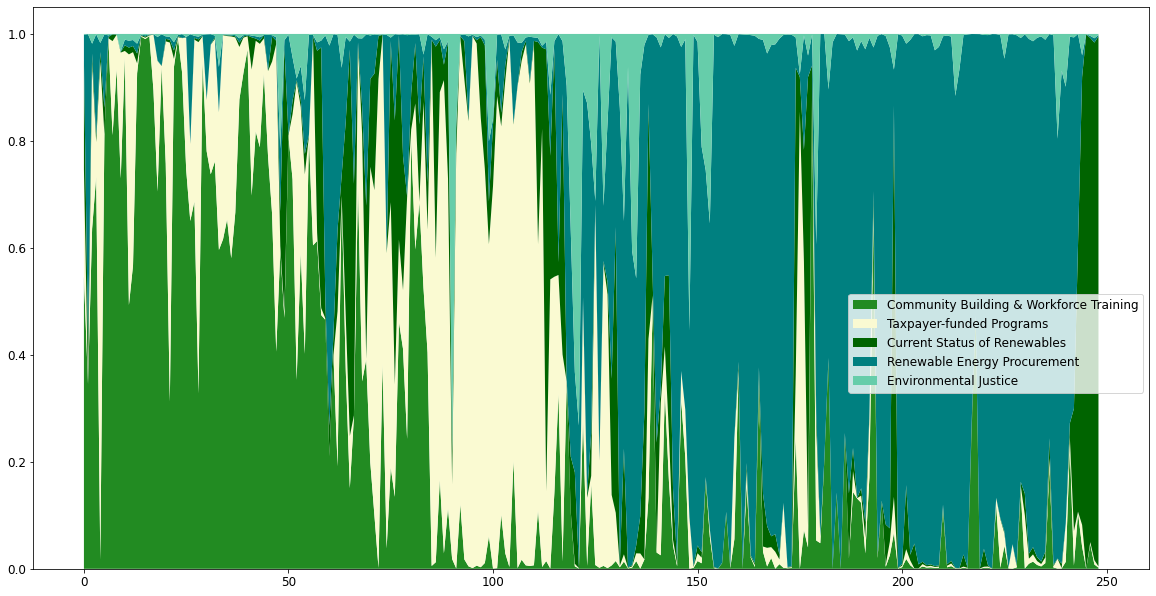

In [134]:
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.stackplot(sections.index, sections['Community Building & Workforce Training'], sections['Taxpayer-funded programs'], sections['Current Status of Renewables'], sections['Renewable Energy Procurement'], sections['Environmental Justice'], labels = ['Community Building & Workforce Training', 'Taxpayer-funded Programs', 'Current Status of Renewables', 'Renewable Energy Procurement', 'Environmental Justice'], colors=['forestgreen', 'lightgoldenrodyellow', 'darkgreen', 'teal','mediumaquamarine']);
plt.legend()
#plt.title('x')
ax.legend(loc='best', bbox_to_anchor=(1, 0.5))

**Look at subset to make visualization more clear and easy to understand**

In [135]:
sections.index[50:60]

RangeIndex(start=50, stop=60, step=1)

In [136]:
sections3 = sections.loc[50:100]

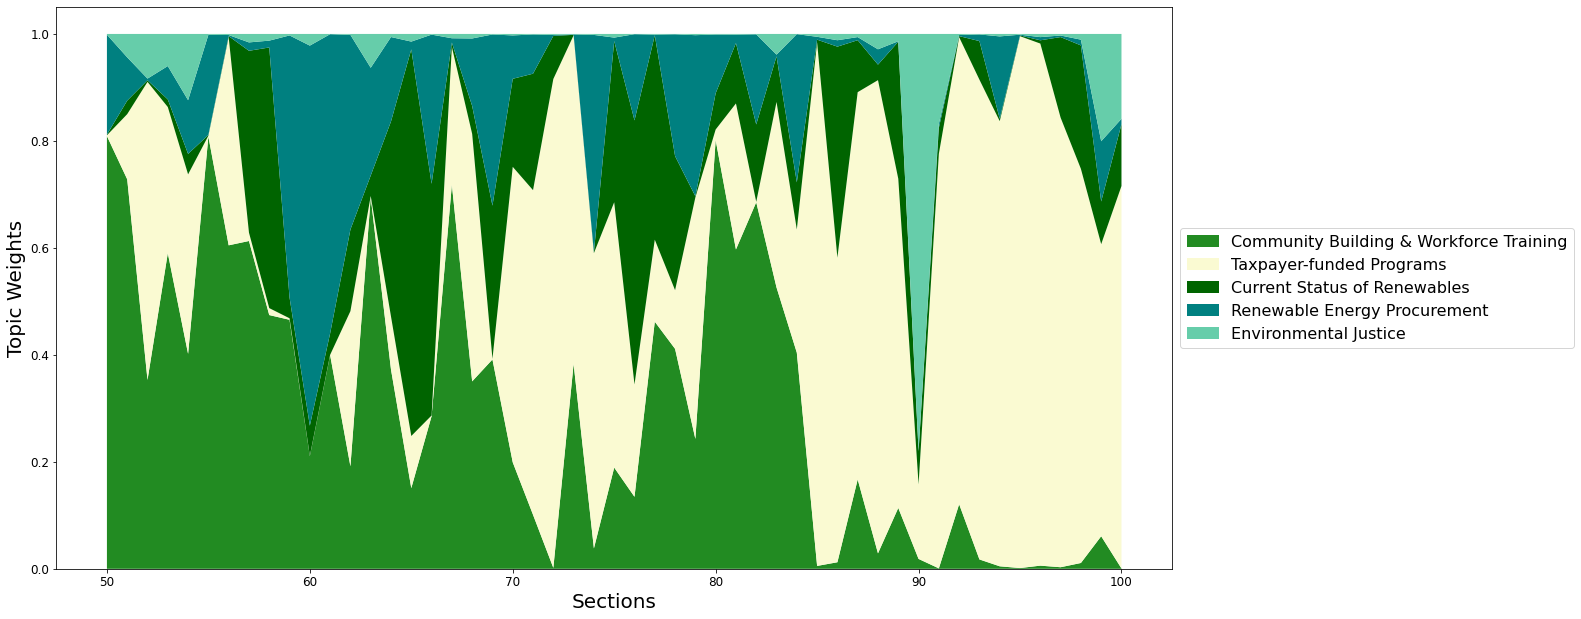

In [137]:
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.stackplot(sections3.index, sections3['Community Building & Workforce Training'], sections3['Taxpayer-funded programs'], sections3['Current Status of Renewables'], sections3['Renewable Energy Procurement'], sections3['Environmental Justice'], labels = ['Community Building & Workforce Training', 'Taxpayer-funded Programs', 'Current Status of Renewables', 'Renewable Energy Procurement', 'Environmental Justice'], colors=['forestgreen', 'lightgoldenrodyellow', 'darkgreen', 'teal','mediumaquamarine']);
plt.legend()
plt.xlabel("Sections")
plt.ylabel("Topic Weights")
#plt.title('x')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 16})
axes = plt.gca()
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)

## Transform topics onto utilities and commissions

In [138]:
utilities

text
0    A gas public utility with\n ,, or more retail customers that is not a combinedHB -  - LRB  SPS  ...
1    A gas\n public utility with fewer than ,, retail customers but\n more than , retail customers th...
2    A gas\n public utility with fewer than , retail customers that\n is not a combined electric and ...
3    Contracts that will be paid with\n funds collected by an electric utility shall be executed\n by...
4    The electric\n utility shall receive and retire all renewable energy\n credits generated by the ...
..                                                                                                   ...
175  The utility shall file with the initial\n procurement plan its proposed tariffs through which it...
176  The electric\n utility shall also recover its full costs of procuring\n electric supply for whic...
177   If the facility is shown to be the least-cost option and is\n included in a procurement plan pr...
178    Subject to Commission specifications established in\n subsection , each utility shall work wit...
179    An electric utility shall recover all of the prudently\n incurred costs of offering a program ...

[180 rows x 1 columns]

In [139]:
utilities['dom_topic'] = utilities.text.apply(lambda x: transform(x))

In [140]:
commission['topics'] = commission.text.apply(lambda x: transform(x))

In [141]:
commission.topics = commission.topics.replace({0: 'Community Building & Workforce Training', 1: 'Taxpayer-funded Programs', 2: 'Status of Renewables', 3: 'Utilities & Renewable Energy Procurement', 4: 'Environmental Justice'})

In [144]:
utilities.dom_topic = utilities.dom_topic.replace({0: 'Community Building & Workforce Training', 1: 'Taxpayer-funded Programs', 2: 'Status of Renewables', 3: 'Utilities & Renewable Energy Procurement', 4: 'Environmental Justice'})

In [145]:
utilities

text  \
0    A gas public utility with\n ,, or more retail customers that is not a combinedHB -  - LRB  SPS  ...   
1    A gas\n public utility with fewer than ,, retail customers but\n more than , retail customers th...   
2    A gas\n public utility with fewer than , retail customers that\n is not a combined electric and ...   
3    Contracts that will be paid with\n funds collected by an electric utility shall be executed\n by...   
4    The electric\n utility shall receive and retire all renewable energy\n credits generated by the ...   
..                                                                                                   ...   
175  The utility shall file with the initial\n procurement plan its proposed tariffs through which it...   
176  The electric\n utility shall also recover its full costs of procuring\n electric supply for whic...   
177   If the facility is shown to be the least-cost option and is\n included in a procurement plan pr...   
178    Subject to Commission specifications established in\n subsection , each utility shall work wit...   
179    An electric utility shall recover all of the prudently\n incurred costs of offering a program ...   

                                    dom_topic  
0    Utilities & Renewable Energy Procurement  
1    Utilities & Renewable Energy Procurement  
2    Utilities & Renewable Energy Procurement  
3    Utilities & Renewable Energy Procurement  
4    Utilities & Renewable Energy Procurement  
..                                        ...  
175  Utilities & Renewable Energy Procurement  
176  Utilities & Renewable Energy Procurement  
177  Utilities & Renewable Energy Procurement  
178  Utilities & Renewable Energy Procurement  
179  Utilities & Renewable Energy Procurement  

[180 rows x 2 columns]

### Look at burdens per topic per entity with most burdens

In [146]:
utilities.groupby('dom_topic').count()

text
dom_topic                                     
Community Building & Workforce Training      3
Environmental Justice                        7
Taxpayer-funded Programs                     2
Utilities & Renewable Energy Procurement   168

In [147]:
groupedcom = commission.groupby('topics').count()

In [148]:
groupedcom.reset_index(inplace=True)

In [149]:
fig = go.Figure([go.Bar(x=groupedcom['topics'], y=groupedcom['text'])])
fig.update_layout(title=go.layout.Title(text="Number of Burdens per Topic for the Energy Transition Workforce Commission"))
fig.show()

In [150]:
ceja[~ceja.subjects.isna()].head(15)

text  \
4   off-peak hours.  (g) The State of Illinois should set forth an ambitious  goal to transition all...   
12  administrator in the Illinois Solar for All program.  "Low-income" means persons and households ...   
13  performance management and corrective action applicable to  these programs.  Section -. Equity a...   
14  input outside of meetings from those with limited capacity and  ability to attend, via one-on-on...   
15  program implementers, and other program partners to  troubleshoot emergent challenges and identi...   
16  Advisory Board upon departures of members. The Advisory Board  shall consist of the following  m...   
17  transgender individuals, and youth;  ()  representatives of clean energy businesses,  nonprofit ...   
18  implementing requirements specified in subsection (b) of this  Section, and identification of op...   
19  this Act.  () The Central Illinois Program Delivery Area  includes areas in or near Peoria, Cham...   
20  (d) The Regional Administrators shall work together to  coordinate the programs listed in paragr...   
21  administration in their respective regions, and the Department  shall also work to create joint ...   
22  outcomes, even after multiple corrective action plans have  been implemented, the Department or,...   
23  resolution between contracted community-based organizations  and their subcontracted entities to...   
24  Section -. Clean Jobs Workforce Hubs Network Program.  (a) The Department shall develop, and thr...   
25  () develop formal partnerships, including formal  sector partnerships between community-based or...   

    burdens                                                         subjects  \
4         1                                                       [agencies]   
12        3                                   [board, opportunity, programs]   
13        4                                  [department, meetings, advance]   
14        6           [board, area, department, approval, programs, program]   
15        8  [department, implementation, activities, processes, act, board]   
16        1                                                          [board]   
17        4                                     [board, members, department]   
18        2                                              [board, department]   
19        2                                                 [administrators]   
20        7                           [administrators, department, programs]   
21        4                                     [department, administrators]   
22        3                              [department, administrators, board]   
23        3                                        [listed, department, act]   
24        2                                            [department, program]   
25        2                                                 [network, sites]   

                                       topic    x_coord    y_coord  
4   Utilities & Renewable Energy Procurement   1.055209  23.503813  
12   Community Building & Workforce Training  27.818371  30.459095  
13   Community Building & Workforce Training  26.607174  30.124443  
14   Community Building & Workforce Training  28.924013  16.677114  
15   Community Building & Workforce Training  27.866949  17.020184  
16   Community Building & Workforce Training  25.016905  30.370417  
17   Community Building & Workforce Training  27.778919  24.187386  
18   Community Building & Workforce Training  27.517576  27.589403  
19   Community Building & Workforce Training  26.625795  29.742445  
20   Community Building & Workforce Training  27.703299  25.436781  
21   Community Building & Workforce Training  28.019012  21.801348  
22   Community Building & Workforce Training  28.141870  19.555725  
23   Community Building & Workforce Training  27.791348  23.284781  
24   Community Building & Workforce Training  27.576927  30.923012  
25   Community Building & Workforce Training  27.925343  29.972658

In [151]:
'department' in ceja.subjects.loc[22]

True

In [152]:
ceja.subjects.loc[22].index

<function list.index(value, start=0, stop=9223372036854775807, /)>

In [153]:
ceja.subjects.apply(lambda x: str(x)), type(ceja.subjects.loc[4])

(0              None
 1              None
 2              None
 3              None
 4      ['agencies']
            ...     
 902         section
 903            None
 904            None
 905            None
 906            None
 Name: subjects, Length: 907, dtype: object,
 list)